In [213]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cmath
from scipy import signal
from sklearn.decomposition import PCA
from IPython.display import clear_output
import pywt
from math import ceil

前3个数值 xx xx xx 对应 小时 分钟 秒  
4个数值 xx xx xx xx 对应 4个天线RSSI（Received Signal Strength Indicator）  
1个数值 x 对应 mcs  
4个数值 x x x x 对应 4个天线gain  
64个复数值对应 Tx1-Rx1的 H  
64个复数值对应 Tx1-Rx2的 H  
64个复数值对应 Tx1-Rx3的 H  
64个复数值对应 Tx1-Rx4的 H  

In [2]:
data1_path = '../数据集/dataset1/'
data2_path = '../数据集/dataset2/'
data3_path = '../数据集/dataset3/'

head_len = 3 + 4 + 1 + 4
length = head_len +64*4
print(length)

268


## 获取这几次数据的 npy 文件的路径

In [3]:
dataset1_npy = [ [data1_path + dirs+'/'+f  for f in os.listdir(data1_path + dirs) if f != '真值' and f.find('npy') != -1] for dirs in os.listdir(data1_path)]
dataset2_npy = [ [data2_path + dirs+'/'+f  for f in os.listdir(data2_path + dirs) if f != '真值' and f.find('npy') != -1] for dirs in os.listdir(data2_path)]
dataset3_npy = [ [data3_path + dirs+'/'+f  for f in os.listdir(data3_path + dirs) if f != '真值' and f.find('npy') != -1] for dirs in os.listdir(data3_path)]

In [134]:
p = dataset1_npy[0][0]
data = np.load(p)
tmp = os.path.dirname(p)
print(p)
print(os.path.dirname(p))
print(os.path.basename(p))

../数据集/dataset1/房间0/csi_2023_09_09_20_55.npy
../数据集/dataset1/房间0
csi_2023_09_09_20_55.npy


## hampel滤波器，使用 3$\sigma$ 来去除异常点

In [5]:
def hampel_filter(data, window_size, n_sigma=3):
    n = len(data)
    filtered_data = data.copy()
    
    for i in range(n):
        if i < window_size // 2:
            window = data[0:i + window_size // 2 + 1]
        elif i >= n - window_size // 2:
            window = data[i - window_size // 2:n]
        else:
            window = data[i - window_size // 2:i + window_size // 2 + 1]
        
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        threshold = n_sigma * 1.4826 * mad  # 1.4826 is a scaling factor for MAD
        
        if abs(data[i] - median) > threshold:
            filtered_data[i] = median
    
    return filtered_data

## 读取数据的函数，同时附上真值

In [230]:
def getData(path, hamFil=True, getValues=False):
    '''
    输入：
        path，数据路径
        hamFil，对时间进行 hampel 滤波，默认为真
    '''
    if not os.path.exists(path):
        raise ValueError(f"{path} not exists")
    data = np.load(path)
    
    
    timeStamp = abs(data[:,0])*3600+ abs(data[:,1])*60 + abs(data[:,2]) # 时分秒
    if hamFil:
        timeStamp = hampel_filter(timeStamp, 40) # 对时间进行滤波
    
    values = np.zeros(ceil(timeStamp[-1]/2))
    
    
    data = np.hstack((data, timeStamp.reshape(-1, 1))) # 末尾添加时间戳
    
    newCol = np.zeros(data.shape[0]).reshape(-1,1) # 标签列
    data = np.hstack((data, newCol))
    
    realValues = os.path.dirname(path) + '/真值/' + os.path.basename(path).replace('npy', 'txt')
    
    # 添加真值
    if not os.path.exists(realValues): # 如果没有，就默认全部是 0 
        print(f'{realValues} not exists')
    else: # 如果有，就在最后一行添加对应的真值
        values = np.loadtxt(realValues)
        startTime = timeStamp[0]
        realValueIdx = 0
        N = data.shape[0]
        for i in range(N): # 每隔 2s 进行一次赋值
            if data[i, -2] > startTime + 2:
                startTime = data[i, -2]
                realValueIdx += 1
            data[i, -1] = values[realValueIdx]
    
    if getValues: # 只返回数据所对应的真值
        return data, values
    
    return data

In [231]:
data, values = getData(dataset2_npy[-1][0], getValues=True)
print(data.shape)

(26505, 270)


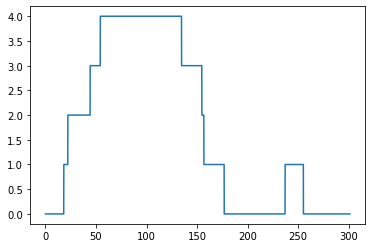

In [232]:
st = 0
L = data.shape[0]
plt.plot(abs(data[st:st+L,-2]), abs(data[st:st+L,-1]))

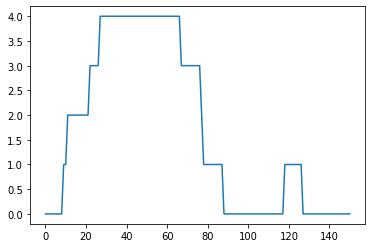

In [234]:
plt.plot(values)

## Weighted Moving Averae(WMA) 加权移动平均

In [6]:
def weighted_moving_average(signal, m = 10, mode='valid'):
    """
    对输入信号进行加权移动平均。

    参数：
    signal (numpy.ndarray)：输入信号的数组。
    weights (numpy.ndarray)：与过往数据相关的长度，默认为 10。

    返回：
    numpy.ndarray：加权移动平均后的信号数组。
    """
#     if len(signal) != len(weights):
#         raise ValueError("信号和权重数组的长度必须相同")
    weights = np.array([m-i for i in range(m)])
    weights = weights /  sum(weights)
    
    result = np.convolve(signal, weights, mode=mode) 
    return result

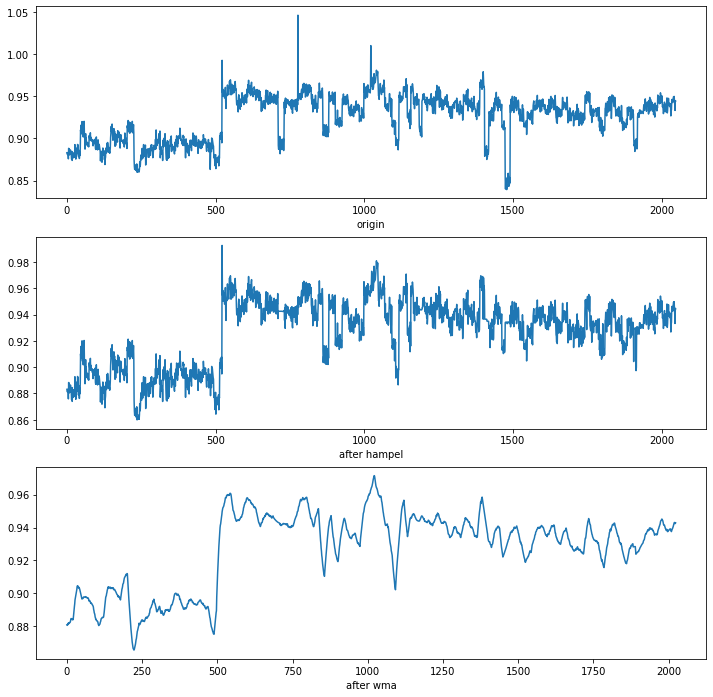

In [7]:
tmp = abs(data[0:2048, head_len+64*2+60])
tmp_hampel = hampel_filter(tmp, 100)
tmp_wma = weighted_moving_average(tmp_hampel, 25)


plt.figure(figsize=(12,12))
plt.subplot(311)
plt.xlabel('origin')
plt.plot(abs(tmp))

plt.subplot(312)
plt.xlabel('after hampel')
plt.plot(abs(tmp_hampel))

plt.subplot(313)
plt.xlabel('after wma')
plt.plot(tmp_wma)

## 同时 hampel + wma 进行滤波

In [8]:
def preprocess(signal, win_size, m,progress=False, mode='valid'):
    num_carrier = signal.shape[1]
    sig_filtered = []
    for i in range(num_carrier):
        tmp1 = hampel_filter(signal[:, i], win_size)
        tmp2 = weighted_moving_average(tmp1, m, mode)
        sig_filtered.append(tmp2)
        if(progress):
            clear_output(wait=True)
            print((i+1)/num_carrier * 100, "%")
    sig_filtered = np.array(sig_filtered).T
    return sig_filtered

In [9]:
c1 = abs(data[0:2048, head_len:head_len + 64])
c1_filtered = preprocess(c1, 100, 50)

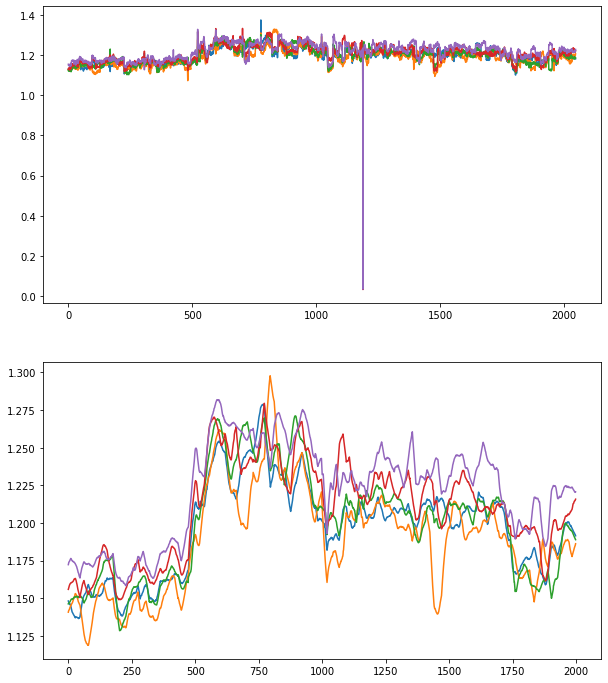

In [10]:

carrier = np.arange(10,15)
plt.figure(figsize=(10,12))
for i in carrier:
    plt.subplot(211)
    plt.plot(c1[:,i])
    plt.subplot(212)
    plt.plot(c1_filtered[:,i])

(1999, 64)
(1999, 64)


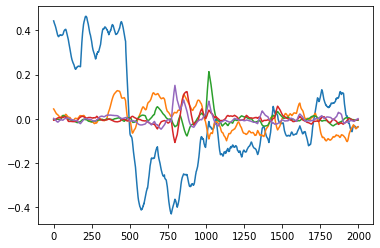

In [11]:

pca = PCA(n_components=64)
c1_pca = pca.fit_transform(c1_filtered)
print(c1_filtered.shape)
print(c1_pca.shape)
for i in range(5):
    plt.plot(c1_pca[:,i])

In [12]:
data1 = np.load(dataset1_npy[-1][0])
print(data1.shape)
N = data1.shape[0]
print(N)

(20907, 268)
20907


In [13]:
r3c1 = abs(data1[0:int(0.5*N), head_len:head_len + 64])
r3c1_filtered = preprocess(r3c1, 150, 100, True)

100.0 %


In [84]:
print(r3c1.shape,'\n', r3c1_filtered.shape)

(10453, 64) 
 (10354, 64)


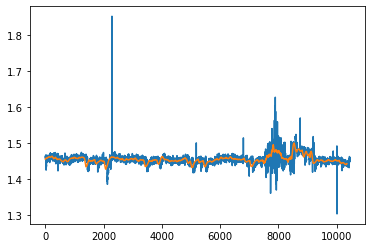

In [15]:
carrier = np.arange(10,11)
# plt.figure(figsize=(5,6))
for i in carrier:
#     plt.subplot(211)
    plt.plot(r3c1[:,i])
#     plt.subplot(212)
#     plt.ylim(1.3, 1.6)
    plt.plot(r3c1_filtered[:,i])

## 小波分析 wavelet

In [17]:
sig = r3c1_filtered[:,12]
coeffs = pywt.wavedec(sig, 'db4', level=3)

In [18]:
print(sig.shape)
print(coeffs[0].shape)

(10354,)
(1300,)


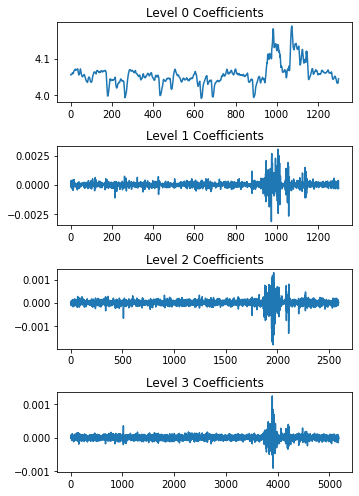

In [19]:
plt.figure(figsize=(5,7))
for i, coeff in enumerate(coeffs):
    plt.subplot(len(coeffs), 1, i + 1)
    plt.plot(coeff)
    plt.title(f'Level {i} Coefficients')
plt.tight_layout()
plt.show()

In [128]:
coeffs_filtered = []

for coeff in coeffs:
    cff = hampel_filter(coeff, 80)
#     cff_wma = weighted_moving_average(cff, 20)
    coeffs_filtered.append(cff)

In [129]:
print(coeffs_filtered[0].shape)
print(coeffs[0].shape)

(1300,)
(1300,)


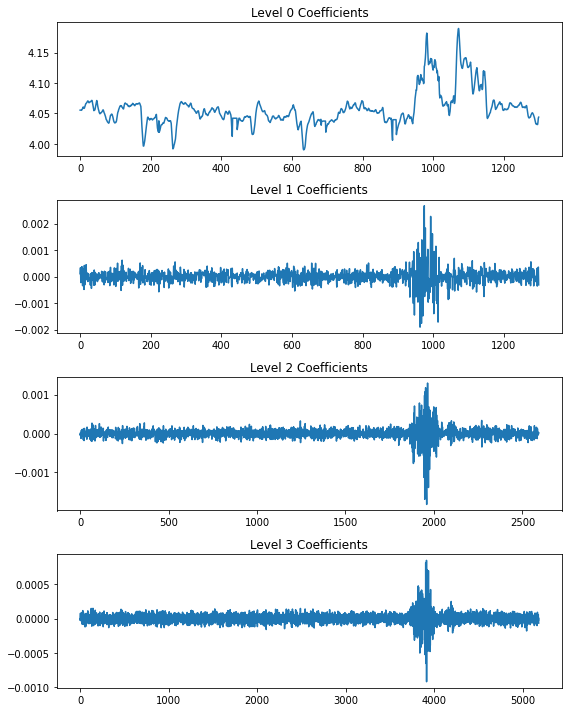

In [130]:
plt.figure(figsize=(8,10))
for i, coeff in enumerate(coeffs_filtered):
    plt.subplot(len(coeffs), 1, i + 1)
    plt.plot(coeff)
    plt.title(f'Level {i} Coefficients')
plt.tight_layout()
plt.show()

In [131]:
reconstructed_signal = pywt.waverec(coeffs_filtered, 'db4')

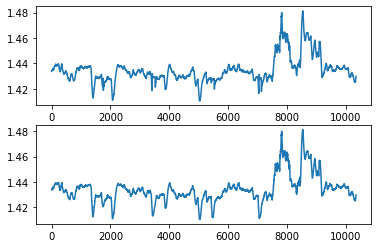

In [134]:
plt.subplot(211)
plt.plot(reconstructed_signal)
plt.subplot(212)
plt.plot(sig)

# 相位分析

In [256]:
data = getData(dataset1_npy[-1][3])
print(data.shape)

(22193, 270)


(22193, 64)


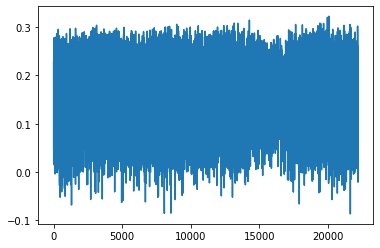

In [326]:
rcv1 = np.angle( data[:, head_len:head_len+64] )
print(rcv1.shape)
avg = np.mean(rcv1, axis=1)
plt.plot(avg)

In [329]:
idx = 11
c_idx = rcv1[:,idx] - (rcv1[:,-1] - rcv1[:,0])/64*(idx+1) - avg

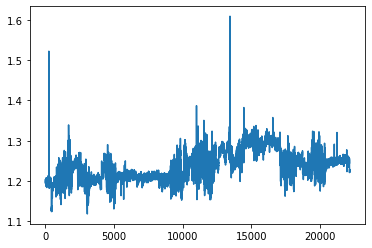

In [332]:
plt.plot(abs(data[:, head_len+23]))

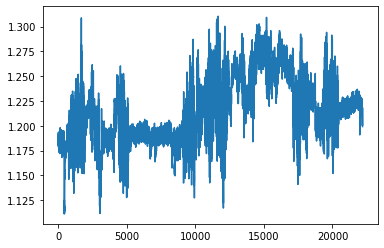

In [364]:
sig = abs(data[:, head_len+26])
sig = hampel_filter(sig, 150)
# sig = weighted_moving_average(sig, 100)
plt.plot(sig)

In [365]:
sig_coeffs = pywt.wavedec(sig, 'db4', level=3)

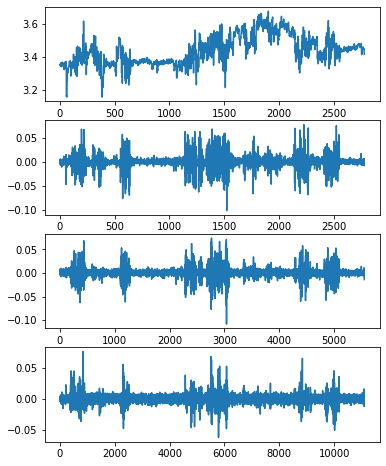

In [366]:
plt.figure(figsize=(6,8))
for i, coeff in enumerate(sig_coeffs):
    plt.subplot(len(sig_coeffs), 1, i+1)
    plt.plot(coeff)

In [367]:
sig_denoised = [pywt.threshold(coef, 0.2, mode='soft') for coef in sig_coeffs]

In [368]:
denoised_sig = pywt.waverec(sig_denoised, 'db4')

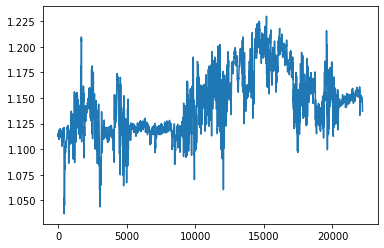

In [369]:
plt.plot(denoised_sig)

In [381]:
import math
from math import log

#sgn函数
def sgn(num):
    if(num > 0.0):
        return 1.0
    elif(num == 0.0):
        return 0.0
    else:
        return -1.0

def wavelet_noising(new_df):
    data = new_df
#     data = data.values.T.tolist()  # 将np.ndarray()转为列表
    w = pywt.Wavelet('dB4')#选择dB10小波基
    ca3, cd3, cd2, cd1 = pywt.wavedec(data, w, level=3)  # 3层小波分解
#     ca3=ca3.squeeze(axis=0) #ndarray数组减维：(1，a)->(a,)
#     cd3 = cd3.squeeze(axis=0)
#     cd2 = cd2.squeeze(axis=0)
#     cd1 = cd1.squeeze(axis=0)

    length1 = len(cd1)
    length0 = len(data)

    abs_cd1 = np.abs(np.array(cd1))
    median_cd1 = np.median(abs_cd1)

    sigma = (1.0 / 0.6745) * median_cd1
    lamda = sigma * math.sqrt(2.0 * math.log(float(length0 ), math.e))
    usecoeffs = []
    usecoeffs.append(ca3)

    #软阈值方法
    for k in range(length1):
        if (abs(cd1[k]) >= lamda/np.log2(2)):
            cd1[k] = sgn(cd1[k]) * (abs(cd1[k]) - lamda/np.log2(2))
        else:
            cd1[k] = 0.0

    length2 = len(cd2)
    for k in range(length2):
        if (abs(cd2[k]) >= lamda/np.log2(3)):
            cd2[k] = sgn(cd2[k]) * (abs(cd2[k]) - lamda/np.log2(3))
        else:
            cd2[k] = 0.0

    length3 = len(cd3)
    for k in range(length3):
        if (abs(cd3[k]) >= lamda/np.log2(4)):
            cd3[k] = sgn(cd3[k]) * (abs(cd3[k]) - lamda/np.log2(4))
        else:
            cd3[k] = 0.0

    usecoeffs.append(cd3)
    usecoeffs.append(cd2)
    usecoeffs.append(cd1)
    recoeffs = pywt.waverec(usecoeffs, w)#信号重构
    return recoeffs

In [382]:
sig_denoised = wavelet_noising(sig)

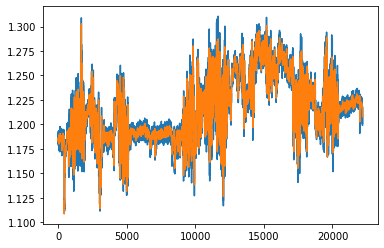

In [383]:
plt.plot(sig)
plt.plot(sig_denoised)